<br>
# **금융과 통계학**
1. 참고사이트 : https://ntguardian.wordpress.com/2016/09/19/introduction-stock-market-data-python-1/
1. 참고사이트 : https://ntguardian.wordpress.com/2016/09/26/introduction-stock-market-data-python-2/

<br>
## **1장 통계학의 개념**
https://www.quantstart.com/articles

<br>
### **01 Value At Risk**
**일일 손실확률**과 **표준편차**를 사용하여, 해당 기간동안 오차범위내 최대 손실가능 금액을 계산한다 [code link](https://www.quantstart.com/articles/Value-at-Risk-VaR-for-Algorithmic-Trading-Risk-Management-Part-I)

    Variance-Covariance calculation of daily Value-at-Risk
    using confidence level c, with mean of returns mu
    and standard deviation of returns sigma, on a portfolio
    of value P.

In [1]:
import datetime
import numpy as np
from scipy.stats import norm

def var_cov_var(P, c, mu, sigma):
    alpha = norm.ppf(1-c, mu, sigma)
    return P - P*(alpha + 1)

# 데이터 불러오기
from googlefinance.get import get_data
stock         = get_data('KRX:005930', '3Y')
stock["rets"] = stock["close"].pct_change()

P     = 1e6      # 1,000,000 원 (초기자금)
c     = 0.99     # 99% 신뢰구간 (confidence interval)
mu    = np.mean(stock["rets"])
sigma = np.std(stock["rets"])
var   = var_cov_var(P, c, mu, sigma)
print ("Value-at-Risk: {:.2f} \nRisk Percent : {:.2f}".format(var, var/P * 100))

Value-at-Risk: 37962.41 
Risk Percent : 3.80


<br>
### **02 자본자산 가격결정모형**
1. 사프-린트너 자본자산 가격결정모형 (CAPM, Capital Asset Pricing Model)
1. 위험과 기대수익률의 관계는 선형적이며, 시장베타가 유일한 위험척도이다
1. **사프와 린트너**가 자산의 기대수익률 $E(r_i)$과 위험지표 $\beta_i$ 사이의 **_선형관계식_** 규칙을 찾아서 적용가능 공식을 발견
1. https://medium.com/python-data/capm-analysis-calculating-stock-beta-as-a-regression-in-python-c82d189db536

In [2]:
# .resample('')
# M : 월말로 종합
# MS : 월초로 종합
# .sum(), .mean()  : 계산 결과값으로 채운다
# .ffill(), bfill() : 대표값을 지정한다 (앞의 값 / 뒤의 값)
# https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.resample.html

from googlefinance.get import get_data
stock = get_data(['KRX:KOSPI200', 'KRX:005930'], '1Y', output='close')  # 'KRX:KOSPI', 
monthly_prices = stock.resample('MS').sum()
monthly_prices.columns = ['KRX', 'SS']
monthly_prices.tail(3)

,KRX,SS
date,,
2018-02-01,5681.92,42524000.0
2018-03-01,6649.22,52168000.0
2018-04-01,3128.98,24323000.0


In [3]:
import pandas as pd
monthly_returns       = monthly_prices.pct_change(1)
clean_monthly_returns = monthly_returns.dropna(axis=0)  # drop first missing

# 인덱스 데이터와 종목 데이터를 분리한다
X = clean_monthly_returns['KRX']
y = clean_monthly_returns['SS']

# 통계적 분석결과 출력
import statsmodels.api as sm
X1      = sm.add_constant(X) # Add a constant to the independent value
model   = sm.OLS(y, X1)      # 회귀 모델을 생성한다
results = model.fit()        # fit model and print results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                     SS   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     1299.
Date:                Mon, 16 Apr 2018   Prob (F-statistic):           6.43e-12
Time:                        13:06:15   Log-Likelihood:                 23.837
No. Observations:                  12   AIC:                            -43.67
Df Residuals:                      10   BIC:                            -42.70
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0050      0.011      0.471      0.6

/home/markbaum/Python/django/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/home/markbaum/Python/django/lib/python3.6/site-packages/scipy/stats/stats.py:1390: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  "anyway, n=%i" % int(n))


In [4]:
# Yahoo 상에서 Beta 값 확인
# https://finance.yahoo.com/quote/005930.KS?p=005930.KS
# 선형 회귀 모델의 기울기를 출력
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(X, y)
print(slope) 

1.0276239967112177


<br>
## **2장 확률의 이해**
http://destrudo.tistory.com/15

<br>
### **01 경험적 확률**
1. 고전적 확률
1. 공리적 확률 (표본적 확률 한계를 극복 : **표본공간 원소들의 발생가능성이 같으면** 고전적 확률과 같아진다) ex) 조건부 집합

<br>
### **02 확률의 계산**
1. 여사건의 확률 : 배반사건의 경우, 모든 확률의 합은 1이다
2. 확률의 덧셈정리 : A,B 합집합 확률 = A의 확률 + B의 확률 - A와B 교집합 확률

<br>
### **03 조건부 확률**
1. 조건부 확률 : **주어진 B**에 따라(**표본 공간의 변경**) , 알고싶은 **A의 발생활 확률**이 달라지는 것 &nbsp;&nbsp; ex) &nbsp;&nbsp; P(A|B)
1. 베이즈 정리 : 초기확률로 부터, **새로운 정보에 따른 변화된 확률**을 계산

<br>
### **04 확률 분포**
1. 확률변수 : 이산형 확률변수(질량함수), 연속형 확률변수(밀도함수)
1. 질량함수(이산형) : 개별 값에 대한 확률이 존재, 총합은 $\Sigma$ 로 누적분포를 계산한다
1. 밀도함수(연속형) : 구간의 확률만 존재하며, 구간의 크기를 0으로 수렴하여 계산한다, 총합은 $\int f(x) dx$ 로 표현된다

<br>
### **05 기댓값과 분산**
1. 기댓값 $\mu$ : 확률분포의 중심으로 상수값을 갖는다.  ex) 0.5 확률결과 + 0.3 확률결과 + 0.2 확률결과 =  전체 기댓값 
1. 분산 $\sigma^2$ : 확률변수와 기댓값의 차이의 제곱 (음수값을 가질수 있어서 모두 양수화를 위해서 제곱한다)
1. 표준편차 $\sigma$ : 분산의 제곱근

<br>
### **06 공분산과 상관계수**
1. 결합확률분포 : $ P ( X = x_i, Y = y_i) $
1. 결합확률질량함수 : $ p (x_i, y_i) $
1. 공분산 $Cov(X,Y)$ : 결합확률분포로 부터 두 변수간의 관계를 파악 가능한 값 (두 확률변수의 편차를 곱한 기댓값의 평균을 계산한다) - 값이 크면 Risk 가 크다
    1. 1 : 두 변수 X, Y 가 같은 방향으로 선형적 이동
    1. -1 : 두 변수 X, Y 가 반대 방향으로 선형적 이동
    1. 0 : 두 변수간 서로 독립니다 (선형관련성이 없다)
1. 상관계수 $\rho$ : 공분산을 각 변수의 표준편차로 나눈 값

<br>
## **3장 확률분호의 이해**
포아송 분포 : https://www.youtube.com/watch?v=nSw5bzZbgd4

<br>
### **01 이산형 확률변수와 관련된 분포**
1. 이산형 균등분포 : 각 값에서의 확률이 동일한 경우의 확률변수
1. 이항분포 1)베루누이 시행 : 오직 2가지 배반적 사건만 가능한 경우 2) 이항분포 : 각 사건의 발생확률을 달리하는 
1. 포아송 분포 $ Posson(\lambda = p \times n) $ &nbsp; : &nbsp; 발생가능성 $p$ 은 매우 낮지만, 시행횟수는 큰 $n$ 확률분포에 활용 ex) 부도가능성 측정
    1. 이항분포에서 기댓값 ($\lambda$) 이 일정한 가정하에 시행횟수 $n$가 커지면서 근사되는 분포를 의미한다
    1. 포아송 분포는 기댓값에 따라서 **확률질량함수**의 모습이 달라진다

<br>
### **02 연속형 확률변수와 관련된 분포**
1. 연속형 균등분포 : 특정 영역에서는 같은 확률을 갖는 확률분포
1. 정규분포 (Normal Distribution)
    1. 기댓값 $\mu$는 **중심의 위치**, 분산 $\sigma$는 **중심으로 부터 퍼진정도** 를 나타낸다
    1. **표준화** : 확률 변수에서 기댓값을 빼고 표준편차로 나눈 변환값으로 단위간의 차지를 없앤뒤 표준정규분포를 이용한다
    1. 정규분포의 퍼센타일 : 신뢰구간 등의 계산시 활용
1. Log 정규분포 
    1. 0보다 큰값을 갖으므로 자산가격을 모형화 하는데 유용하다
    1. Log 정규분포 확률밀도함수는 치우쳐 있는 모습을 갖는다
    1. $\mu, \sigma^2$가 커짐에 따라 꼬리가 짧아진다
    1. 분산이 평균에 비례하여 증가한다
    
<img src="https://upload.wikimedia.org/wikipedia/commons/8/80/Some_log-normal_distributions.svg" width='250' align='left'>

<br>
## **4장 확률분포의 응용**
주가 시계열 시뮬레이션 : https://jtsulliv.github.io/stock-movement/

<br>
### **01 결합확률분포**
1. 이변량 정규분포형 균등분포 : 각 값에서의 확률이 동일한 경우의 확률변수
1. 확률변수 합의 분포
1. 포트폴리오 분포
    1. 포트폴리오 기대수익률 &nbsp; : &nbsp; 투자비중_1 X A종목 수익률 &nbsp;&nbsp; + &nbsp;&nbsp; 비중_2 X B종목 수익률 .....
    1. 포트폴리오 분산 : $ Var(Z) = Var(w_1X + w_2Y) $

<br>
### **02 확률과정**
1. 확률과정 : 개별 일자의 확률은 해당일자에만 의존하는 **무기억성**을 갖고, 이러한 성징을 갖는 확률과정을 마코프 과정(Markov)이라 한다
1. 위너과정(Wiener process) 
1. 이항나무모형(binomial tree) [code](http://andrew.gibiansky.com/blog/economics/binomial-options-pricing-model/): 내일 변화가능성이 10%상승, 10%하락 2가지만 가능시 모델을 만들어서 가치를 계산가능하다
1. 기하브라운 운동(Geometric Brownian motion) : 금융상품은 **짧은기간 (dt) 로그수익률** 은 평균($\mu dt$) 와 분산($\sigma^2 dt$)인 **정규분포를 따르는 기하브라운 운동**을 한다

In [5]:
np.random.standard_normal(1)

array([1.40467357])

In [6]:
# Log 데이터를 활용한 브라운운동 모델 만들기
# Log 수익률 변화가 정규분포를 따를 때 미래가치를 예측한다
import numpy as np

seed = 3         # 초기값 : 초기값에 따라서 모형이 전혀 다르게 바뀐다
N    = 2.**6     # 전체 증가분 : 64개 

def Brownian(seed, N):
    np.random.seed(seed)                         
    dt = 1. / N                                          # 1단위 시간 간격
    b  = np.random.normal(0., 1., int(N)) * np.sqrt(dt)  # 개별 brownian 운동값을 계산한다
    W  = np.cumsum(b)                                    # brownian 변동 누적합을 계산한다
    return W, b

Brownian(seed, N)

(array([ 0.22357856,  0.27814229,  0.29020447,  0.05726789,  0.02259436,
        -0.02175051, -0.0320932 , -0.11046828, -0.11594555, -0.17559781,
        -0.3398309 , -0.2292531 , -0.11908835,  0.09460829,  0.10086249,
         0.05027781, -0.01789218, -0.21120184, -0.08840591, -0.22603937,
        -0.37417018, -0.39987642, -0.21410788, -0.18451834, -0.31249149,
        -0.40161564, -0.32346002, -0.34352419, -0.43962873, -0.46838257,
        -0.37525054, -0.12823669, -0.28375211, -0.36205422, -0.46252498,
        -0.76491038, -0.88038438, -1.00836885, -0.86787161, -0.88436088,
        -1.08727157, -1.00643713, -1.05097098, -1.26886361, -1.34344481,
        -1.41701911, -1.5262544 , -1.52254017, -1.80357239, -1.83704263,
        -1.7103947 , -1.60379497, -1.46527153, -1.3253477 , -1.1394048 ,
        -1.27919239, -1.17346321, -1.40607441, -1.48143504, -1.72074405,
        -1.58972561, -1.42300838, -1.44768522, -1.22585459]),
 array([ 0.22357856,  0.05456373,  0.01206218, -0.23293659, -0

Text(0.5,1,'Brownian Increments')

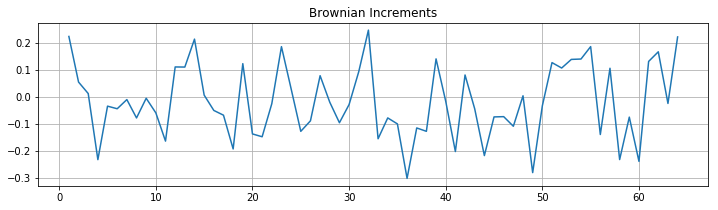

In [7]:
# 개별 브라운 증가운동을 시각화 한다
b = Brownian(seed, N)[1]   

%matplotlib inline
import matplotlib.pyplot as plt
xb = np.linspace(1, len(b), len(b))
plt.figure(figsize=(12,3))
plt.plot(xb, b); plt.grid(); plt.title('Brownian Increments')

Text(0.5,1,'Brownian Motion')

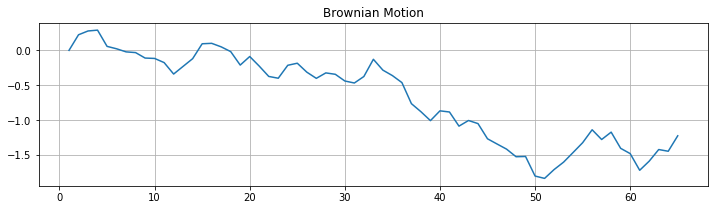

In [8]:
# 누적 브라운 운동 모형을 시각화 한다
W = Brownian(seed, N)[0]   # brownian motion
W = np.insert(W, 0, 0.)    # W_0 = 0. for brownian motion

xw = np.linspace(1, len(W), len(W))
plt.figure(figsize=(12,3)); plt.plot(xw, W); plt.grid(); plt.title('Brownian Motion')

<br>
### **03 시뮬레이션**
1. 역사적 시뮬레이션 : 과거의 패턴이 지속됨을 전제로 분석을 실시한다 ex) Value At Risk
2. 몬테카를로 시뮬레이션 : 특정한 확률분포로부터 확률적 난수를 생성하여 불확실한 현실을 모의적으로 살펴본다

<br>
#### **1) 몬테카를로 시뮬레이션 01**
랜덤워크 주가의 운동 예측 [Code](http://www.pythonforfinance.net/2016/11/28/monte-carlo-simulation-in-python/) | http://www.pythonforfinance.net/2016/11/28/monte-carlo-simulation-in-python/


In [9]:
# 몬테카를로 시뮬레이션
import math
import numpy as np
from scipy.stats import norm
from googlefinance.get import get_data_yahoo, get_data
stock         = get_data('NASDAQ:AAPL', '1Y')
stock["rets"] = stock["close"].pct_change()
stock.tail(3)

,code,open,high,low,close,volume,rets
date,,,,,,,
2018-04-12,NASDAQ:AAPL,172.23,173.9232,171.70,172.44,22431640,-0.004675
2018-04-13,NASDAQ:AAPL,173.41,175.0000,173.04,174.14,22889285,0.009859
2018-04-14,NASDAQ:AAPL,174.78,175.8400,173.85,174.73,25124255,0.003388


In [10]:
S     = stock['close'][-1]       # 1,000,000 원 (초기가격)
T     = 252                     # 시뮬레이션 기간을 지정한다 (Number of trading days)
mu    = np.mean(stock["rets"])
vol   = np.std(stock["rets"])   # 변동성 : 주가 변화의 표준편차
vol

0.013239967277687286

In [11]:
# 모형의 변수들을 정의한다
# S   = apple['close'][-1]  # 마지막 종가를 추출한다
# T   = 252                     # 시뮬레이션 기간을 지정한다 (Number of trading days)
# mu  = 0.2309                  # Return
# vol = 0.4259                  # 변동성 (Volatility)
daily_returns = np.random.normal(mu / T, vol / math.sqrt(T), T) + 1  # 1년간 발생가능한 가격을 시뮬레이션 한다
print(S)
daily_returns[:10]

174.73


array([0.99944091, 1.00012928, 1.00013122, 0.99911608, 1.00036892,
       1.00162084, 0.99914883, 1.00075374, 0.9998748 , 1.0014796 ])

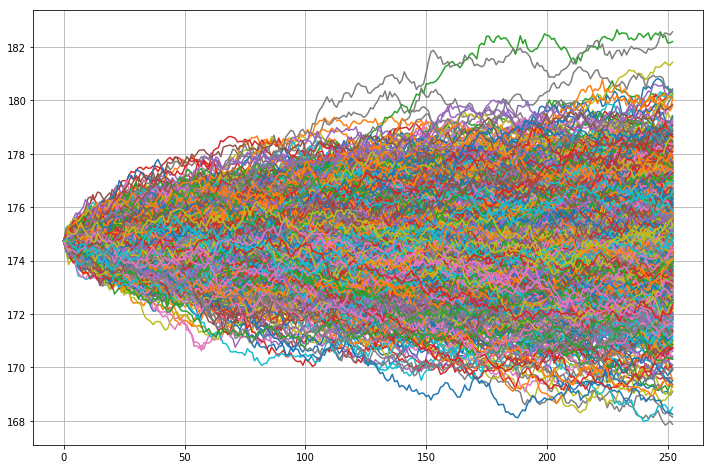

In [12]:
import matplotlib.pyplot as plt
result = []
plt.figure(figsize=(12,8))

for i in range(1000): # 시뮬레이션 횟수를 지정한다
    daily_returns = np.random.normal(mu / T, vol / math.sqrt(T), T) + 1  # 매일의 종가를 시뮬레이션 한다
    price_list = [S]                           # 초기값을 불러온다    
    for x in daily_returns:
        price_list.append(price_list[-1] * x)  # 직전 모형의 마지막 값을 불러온다
    plt.plot(price_list)                       # 시뮬레이션 결과를 쌓아 나아간다
    result.append(price_list[-1])              # 개별 모형의 마지막 값을 저장한다
plt.grid(); plt.show() # 전체 그래프를 출력

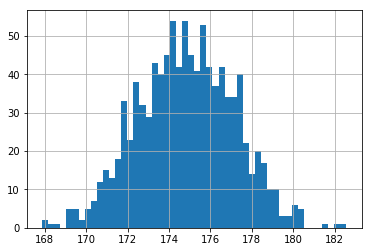

In [13]:
# 개별 모형의 히스토그램을 출력한다
plt.hist(result, bins = 50)
plt.grid(); plt.show()

In [14]:
# 모형의 평균가격을 계산한다
# 5% 에 해당하는 모형의 가격을 출력
# 95%에 해당하는 모형의 가격을 출력
print(round(np.mean(result), 2))
print("5% quantile =",  np.percentile(result,5))
print("95% quantile =", np.percentile(result,95))

174.83
5% quantile = 171.0088478889166
95% quantile = 178.5385259034124


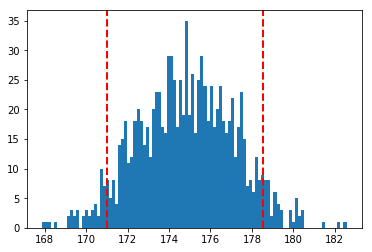

In [15]:
plt.hist(result, bins = 100)
plt.axvline(np.percentile(result, 5),  color='r', linestyle='dashed', linewidth=2)
plt.axvline(np.percentile(result, 95), color='r', linestyle='dashed', linewidth=2)
plt.show()

<br>
#### **2) 몬테카를로 시뮬레이션 02**
포트폴리오 종목의 분산 최적화 [Code](http://www.pythonforfinance.net/2017/01/21/investment-portfolio-optimisation-with-python/) | http://www.pythonforfinance.net/2017/01/21/investment-portfolio-optimisation-with-python/

In [16]:
# 1종목의 주가 운동을 분석하는 방법
import numpy as np
import pandas as pd
stock.sort_index(inplace=True) 

data              = stock.close 
returns           = data.pct_change()
mean_return       = returns.mean()
return_stdev      = returns.std()
annualised_return = round(mean_return * 252 * 100, 2)
annualised_stdev  = round(return_stdev * np.sqrt(252), 2)

print ('1)현재 종가가 {} 인 해당종목의 연간 예상수익은 {}% 이고, ' 
        '\n2)연간 변동성 (표준편차) 값은 {} 이다'.format(data[0],
                                           annualised_return,
                                           annualised_stdev))

1)현재 종가가 141.83 인 해당종목의 연간 예상수익은 23.24% 이고, 
2)연간 변동성 (표준편차) 값은 0.21 이다


In [17]:
# 2 여러종목의 분산비율 적용시 예상수익과, 변동성 측정
from googlefinance.get import get_data_yahoo, get_data
codes = ['NASDAQ:AAPL', 'NASDAQ:AMZN', 'NASDAQ:MSFT', 'NASDAQ:GOOGL']
stocks = get_data(codes, '1Y', output='close')

#  여러 종목의 운동을 비교하여 분산하는 방법
stocks.sort_index(inplace=True)
portfolio_rate     = [0.5, 0.2, 0.2, 0.1]
returns            = stocks.pct_change()         # 종가를 일간 변동률로 변환한다
mean_daily_returns = returns.mean()             # 일간 변동률의 평균
cov_matrix         = returns.cov()              # 일간 변동률의 공분산
weights            = np.asarray(portfolio_rate) # Portfolio 분산비율을 : 'array'방식으로 변환
portfolio_return   = round(np.sum(mean_daily_returns * weights) * 252,2)   # 포트폴리오의 연간 변동률 계산
portfolio_std_dev  = round(np.sqrt(np.dot(weights.T, 
                                          np.dot(cov_matrix, weights))) * np.sqrt(252),2) 
print('{} 분산비율의 포트폴리와 연간 수익은 +-{} 이고, 변동률은 {} 이다'.format(
    portfolio_rate, 
    portfolio_return,
    portfolio_std_dev))

[0.5, 0.2, 0.2, 0.1] 분산비율의 포트폴리와 연간 수익은 +-0.31 이고, 변동률은 0.19 이다


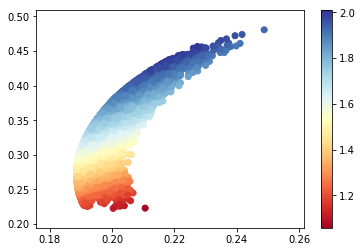

In [18]:
# 3 몬테카를로 시뮬레이션을 활용한 최적의 비율 찾기 
stocks.sort_index(inplace=True)
returns            = stocks.pct_change()
mean_daily_returns = returns.mean()
cov_matrix         = returns.cov()
 
num_portfolios = 25000                         # 몬테카를로 시뮬레이션 횟수를 정의한다
results        = np.zeros((3,num_portfolios))  # 결과값을 저장 할 Zero Array를 생성
 
for i in range(num_portfolios):
    weights = np.random.random(4)   # 난수 혼합비율 값을 생성한다
    weights /= np.sum(weights)      # 난수 전체의 합이 1이 되도록 Rebalance를 한다     
    portfolio_return  = np.sum(mean_daily_returns * weights) * 252  # 포트폴리오 전체의 평균을 계산 : 확률의 덧셈정리
    portfolio_std_dev = np.sqrt(np.dot(weights.T,                   # 포트폴리오 전체의 변동률 계산
                                       np.dot(cov_matrix, weights))) * np.sqrt(252)   
    results[0,i] = portfolio_return    # 평균을 0번 인덱스에 저장
    results[1,i] = portfolio_std_dev   # 변동률을 1번 인덱스에 저장
    # 사프지수 Sharpe Ratio :  (return / volatility) - risk free rate element excluded for simplicity
    results[2,i] = results[0,i] / results[1,i]  # 사프지수를 2번 인덱스에 저장
 
results_frame = pd.DataFrame(results.T,
                             columns = ['ret','stdev','sharpe'])  # 데이터 프레임으로 변환한다
   
# 포트폴리오 결과값들을 산점도로 시각화 한다
plt.scatter(results_frame.stdev,   # X축 
            results_frame.ret,     # Y축
            c = results_frame.sharpe,
            cmap = 'RdYlBu')
plt.colorbar()

In [19]:
# 4. 최적화된 분산비율을 추출한다
# set number of runs of random portfolio weights
num_portfolios = 25000
results        = np.zeros((4 + len(codes) - 1,
                           num_portfolios))
results.shape

for i in range(num_portfolios):
    weights = np.array(np.random.random(4))
    weights /= np.sum(weights)
    portfolio_return  = np.sum(mean_daily_returns * weights) * 252
    portfolio_std_dev = np.sqrt(np.dot(weights.T,np.dot(cov_matrix, weights))) * np.sqrt(252)
    
    results[0,i] = portfolio_return
    results[1,i] = portfolio_std_dev
    results[2,i] = results[0,i] / results[1,i]

    # 반복자(iterate)를 통해서 개별 벡터들의 연산결과를 저장한다
    for j in range(len(weights)):
        results[j+3, i] = weights[j]
        
results_frame = pd.DataFrame(
    results.T,
    columns = ['ret', 'stdev', 'sharpe', codes[0], codes[1], codes[2], codes[3]])

results_frame.head(3)

,ret,stdev,sharpe,NASDAQ:AAPL,NASDAQ:AMZN,NASDAQ:MSFT,NASDAQ:GOOGL
0,0.301965,0.190319,1.586630,0.400070,0.074937,0.358938,0.166055
1,0.314831,0.197780,1.591829,0.076063,0.062911,0.491724,0.369303
2,0.373261,0.199371,1.872191,0.212797,0.298012,0.429659,0.059531


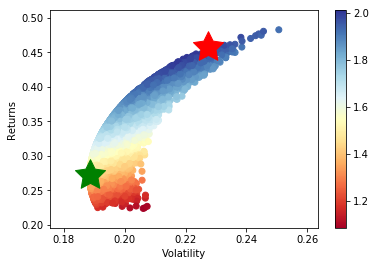

In [20]:
max_sharpe_port = results_frame.iloc[results_frame['sharpe'].idxmax()] # 사프지수 최대값인 인자값을 추출
min_vol_port    = results_frame.iloc[results_frame['stdev'].idxmin()]  # 표준편차가 최소인 인자값을 추출
 
# create scatter plot coloured by Sharpe Ratio
plt.scatter(results_frame.stdev,
            results_frame.ret,
            c = results_frame.sharpe,
            cmap = 'RdYlBu')
plt.xlabel('Volatility')
plt.ylabel('Returns')
plt.colorbar()

# plot red star to highlight position of portfolio with highest Sharpe Ratio
plt.scatter(max_sharpe_port[1],
            max_sharpe_port[0],
            marker = (5,1,0),
            color = 'r',
            s = 1000)

# plot green star to highlight position of minimum variance portfolio
plt.scatter(min_vol_port[1],
            min_vol_port[0],
            marker = (5,1,0),
            color = 'g',
            s = 1000)

In [21]:
# 사프지수 최대로 갖는 포트폴리오 비율 	
print(max_sharpe_port)

ret             0.457149
stdev           0.227402
sharpe          2.010311
NASDAQ:AAPL     0.000524
NASDAQ:AMZN     0.664919
NASDAQ:MSFT     0.330427
NASDAQ:GOOGL    0.004130
Name: 23925, dtype: float64


In [22]:
# 변동성을 최소로 갖는 포트폴리오 비율
print(min_vol_port)

ret             0.272480
stdev           0.188618
sharpe          1.444612
NASDAQ:AAPL     0.425152
NASDAQ:AMZN     0.070449
NASDAQ:MSFT     0.182295
NASDAQ:GOOGL    0.322104
Name: 9804, dtype: float64


<br>
## **5장 금융데이터 정리와 요약**
Pandas.pct_change() : https://www.youtube.com/watch?v=MSXGbXJiTt4

<br>
### **01 히스토그램**
1. 도수분포표(frequency distribution table) : 구간에 대한 종가비율 도수 분포
1. 히스토그램 (HistoGram) : 계급에 따른 도수로써 원 데이터의 정보는 부분적으로 손실된다

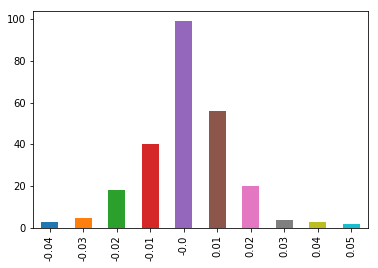

In [23]:
# 도수 분포표
stock_static = stock.close.pct_change().dropna()

# 소숫점 2째 자리에서 반올림 (10% 단위로 도수 분포를 나눈다)
static = pd.Series([round(static,2)  for static in stock_static])
static = static.value_counts()
static = static.sort_index()
static.plot(kind='bar')

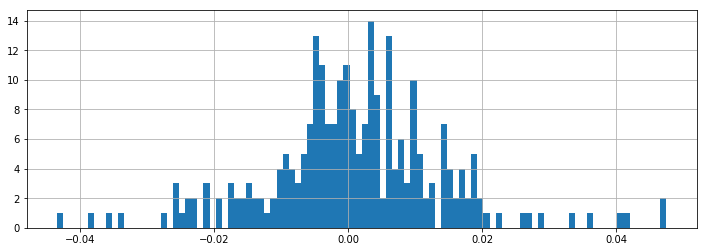

In [24]:
# 히스토 그램
plt.figure(figsize=(12,4)); plt.grid()
plt.hist(stock_static, bins = 100)
plt.show()

<br>
### **02 중심값**
1. 표본평균 (sample mean) : 데이터 분포의 중심위치 측도
1. 중앙값 (median) : 특이점에 의해 평균이 오염되는 단점을 보완
1. 최빈값 (mode)

<br>
### **03 변동성**
1. 분산과 표준편차
1. 사분위범위 : Box-plot 을 사용하면 쉽게 파악 가능하다


<br>
### **04 왜도와 첨도**
1. 왜도(skewness) : 데이터의 대칭성을 파악
1. 첨도(kurtosis) : 꼬리 부분 데이터 분포

<br>
### **05 확률분포의 추정**
PDF [Python for Finance](http://andras.niedermayer.ch/wp-content/uploads/2018/04/Python_for_Finance_Lecture_6.pdf)
1. BoxPlot : 사분위수와 최대/ 최솟값 5개의 숫자를 그래프로 시각화
1. 확률밀도함수의 추정 [Python](https://datascienceschool.net/view-notebook/4d74d1b5651245a7903583f30ae44608/)
1. http://andras.niedermayer.ch/teaching/

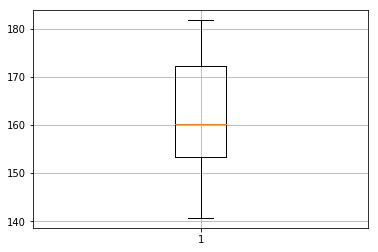

In [25]:
# Box Plot
plt.boxplot(stock.close)
plt.grid()

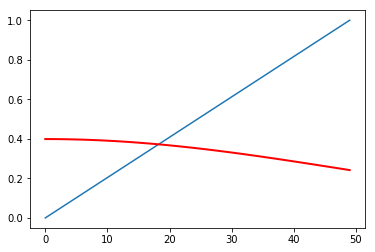

In [38]:
# 출처 (https://datascienceschool.net/view-notebook/4d74d1b5651245a7903583f30ae44608/)
# Log 수익률 히스토그램의 확률밀도함수 추정
import scipy.stats as scs
x = np.linspace(plt.axis()[0], plt.axis()[1])
x_ = [i  for i in range(len(x))]
plt.plot(x)
plt.plot(x_, scs.norm.pdf(x),#, loc = r/M, scale=sigma/np.sqrt(M)),
         'r' , 
         lw = 2.0, 
         label = '확률밀도함수(pdf)')

<br>
## **6장 표본분포와 추정**
Pandas.pct_change() : https://www.youtube.com/watch?v=MSXGbXJiTt4

<br>
### **01 표본평균의 분포**
1. 표본평균의 분포
1. t분포

<br>
### **02 표본분산의 분포 [python](http://hamelg.blogspot.kr/2015/11/python-for-data-analysis-part-25-chi.html)**
1. 카이제곱분포 [개념설명](https://bookdown.org/mathemedicine/Stat_book/-.html) 
    1. 카이 X는, 그리스 알파벳으로 평균0 분포1인 **표준정규분포**를 갖는다 
    1. 이러한 표준정규분포 **v 개를 결합**하여 개별 **카이제곱분포 모델**을 생성한다
    1. **비대칭 정도**는 자유도에 의존하며, 자유도가 커질수록 분포의 모습이 대칭적으로 된다
    1. **카이제곱은 분산**의 **제곱값에 대한 분포로 (+) 값만 존재**하며 **좌우 비대칭**의 분포를 따른다
    1. 직접 확률을 구할 때 사용하는 분포가 아니라, **신뢰 구간과 가설검정, 독립성 검정**등에 사용한다
1. F 분포 [개념설명](http://godrag77.blogspot.kr/2011/07/f-f-distribution.html)
    1. **모델의 비교**시 일반적으로는 평균을 사용하지만, 특별한 경우 **분산**을 사용한다
    1. 즉 데이터의 분포가 같은지를 판단하기 위해 분산을 이용한다
    1. 표본분산은 **카이제곱분포**를 따르므로, 표본분산비는 **두개의 독립인 카이제곱분포 통계량의 비**로 표현한다
    1. 이때 표본분산의 비는 **F분포**를 따른다
    1. **분자의 자유도**와 **분모의 자유도**가 커질 수록 정규분포에 가까워진다
    1. 용도는 1)두 모분산의 비교, 추정 및 검정, 2) 분산분석 및 회귀분석 에 활용한다

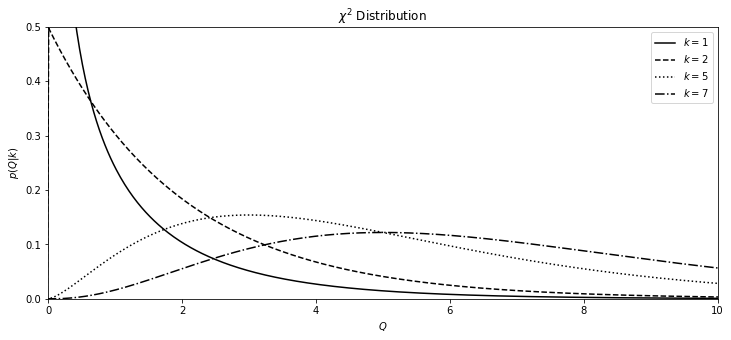

In [49]:
# http://www.astroml.org/book_figures/chapter3/fig_chi2_distribution.html
# 카이제곱 모델의 생성
import numpy as np
from scipy.stats import chi2
from matplotlib import pyplot as plt

mu, k_values = 0, [1, 2, 5, 7]
linestyles   = ['-', '--', ':', '-.']
x            = np.linspace(-1, 20, 1000)
fig, ax      = plt.subplots(figsize=(12, 5))

for k, ls in zip(k_values, linestyles):
    dist = chi2(k, mu)
    plt.plot(x, dist.pdf(x), 
             ls = ls, 
             c = 'black',
             label = r'$k=%i$' % k)

plt.xlim(0, 10); plt.ylim(0, 0.5); plt.legend()
plt.xlabel('$Q$'); plt.ylabel(r'$p(Q|k)$'); plt.title(r'$\chi^2\ \mathrm{Distribution}$'); plt.show()

<br>
### **03 대수의 법칙**
1. 대수의 법칙 : 모집단과 표본평균의 관계
1. 중심극한정리
    1. 모집단이 **베르누이 분포 (True/False 2가지만 가능)** 를 따를 때, 표본비율은 정규분포로 근사된다
    1. 분포가 정규분포가 아니여도, n값이 충분히 크면 표본평균은 정규분포에 근사함을 수학적으로 증명하였다

<br>
### **04 점 추정**
1. 추정의 원리
    1. 표본으로 부터 **통계적 추론**으로 모집단을 추측한다
    1. **점추정** (모수에 대해 하나의 값을 추정)과 **구간추정** (모수가 포함될 것으로 기대되는 범위로 추정) 방법이 있고
    1. **구간추정**은 모수 추정과 더불어, 정확도를 함께 제시한다
    1. **검정**은 모집단에 대한 주장의 타당성을 표본을 통해서 점검하는 것을 의미한다
    1. 바람직한 추정을 위해서는, **불편성, 일치성, 효율성**을 갖는다
    1. **불편성** : 통계값의 평균이 모수와 같게 되는 특성
    1. **일치성** : 표본의 크기가 커질수록 추정값이 모수에 가까워 지는 것
    1. **효율성** : 추정량의 분산이 작음을 의미
1. 모평균의 추정
1. 모분산의 추정
1. 모비율의 추정

<br>
### **05 구간추정**
1. 모평균의 구간추정 : 정규분포의 신뢰구간을 응용하여, 모평균의 범위를 특정한다
1. 모분산의 구간추정
1. 모비율의 구간추정

<br>
## **7장 가설점정**
의사결정의 기준을 제시한다

<br>
### **01 가설검정의 개요**
1. 가설검정과 가설
    1. **대립가설(연구가설)** : 귀무가설에 대립하는 명제로, **뚜렷한 증거에 의거하여 주장하고자 하는 가설**
    1. **귀무가설** : **나의 주장은 False로 되돌리는 가설**
    1. **유의수준** : 귀무가설이 타장함을 전제로, **귀무가설의 오류확률**을 측정한다
1. T 검정 (**유의수준**) : 오류의 발생확률 최대 허용한계
    1. 유의수준 (95%, 5%) 범위내 유효한 값 < **P-value** &nbsp;&nbsp; : &nbsp;&nbsp; 귀무가설을 기각, **대립가설이 타당**
    1. **유의수준 (95%, 5%) 범위내 유효한 값** > P-value &nbsp;&nbsp; : &nbsp;&nbsp; **귀무가설이 유지**
1. 가설검정의 오류 (검정력)
    1. 1종오류 : (덜렁이 실수, 근거부족) **연구가설이 근거가 부족**함에도, 있는걸로 착각
    1. 2종오류 : (멍청이 실수, 조작미숙) **연구가설이 타당**함에도, 귀무가설을 기각하지 못함   

<br>
### **02 모평균의 검정**
1. 모평균의 검정 : 대립가설과 기격역
1. 모비율의 검정 : 대립가설과 기각역
1. 모평균 차이의 검정

<br>
### **03 모분산의 검정**
1. 모분산의 검정
1. 모분산 비의 검정

<br>
### **04 검정과 구간추정**
### **05 여러가지 검정**
1. 비모수 검정
1. 분할표를 이용한 검정

<br>
## **8장 상관분석과 회귀분석**
의사결정의 기준을 제시한다

<br>
### **01 상관분석**
1. 산점도
1. 상관분석

<br>
### **02 단순회귀모형의 개요**
모형의 구조(regression analysis)

<br>
### **03 단순회귀모형의 추정**
1. 최소제곱법(least Square Estimation)
1. 추정량의 성질
1. 추정량의 검정

<br>
### **04 단순회귀모형의 적합도**
1. 회귀모형의 적합도 
1. 분산분석표 : 종속변수 관측값의 변동을 제곱합으로 나타내고, 이들을 분해하여 회귀모형의 의미를 찾는 분석방법

<br>
### **05 단순회귀모형의 진단과 예측**
1. 단순회귀모형의 진단 : 잔차 오차항 가정에 부합여부를 판단 (Mean Square Error)
1. 추정계수의 이해
1. 단순회귀모형의 예측

<br>
## **9장 중회귀분석과 로지스틱회구분석**
중회귀모형

<br>
### **01 중회귀모형의 작성**
1. 산점도
1. 상관분석